### Welcome to the dot calling notebook!

Punctate pairwise peaks of enriched contact frequency are a prevalent feature of mammalian interphase contact maps. These features are also referred to as ‘dots’ or ‘loops’ in the literature, and can appear either in isolation or as parts of grids and at the corners of domains.

HiCCUPS, proposed in [Rao et al. 2014](https://doi.org/10.1016/j.cell.2014.11.021), is a common approach for detecting these features in Hi-C maps. However, HICCUPS is written in Java, making it hard to modify the parameters for specific steps.

Cooltools implements a similar approach for calling dots in Python. This makes it easy to vary parameters and processing steps for Hi-C or Micro-C datasets.%load_ext autoreload
%autoreload 2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from itertools import chain

# Hi-C utilities imports: 
import cooler
import bioframe
import cooltools
from cooltools.lib.numutils import fill_diag

# Visualization imports: 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib.patches as patches
from matplotlib.ticker import EngFormatter

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True, formatter=bp_formatter):
    """format ticks with genomic coordinates as human readable"""
    if y:
        if formatter is not None:
            ax.yaxis.set_major_formatter(formatter)
    if x:
        if formatter is not None:
            ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
%matplotlib inline

### Load data and define genomic view

To call dots, we need an input cooler file with Hi-C data, and regions for calculation of expected (e.g. chromosomes or chromosome arms).

In [5]:
from cooltools.lib import plotting

In [6]:
# Download the test data from osf and define cooler:
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
# 10 kb is a resolution at which one can clearly see "dots":
binsize = 10_000
# Open cool file with Micro-C data:
clr = cooler.Cooler(f'./test.mcool::/resolutions/{binsize}')

In [7]:
# define genomic view that will be used to call dots and pre-compute expected

# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler. 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()

# intra-arm expected
expected = cooltools.expected_cis(
    clr,
    view_df=hg38_arms,
    nproc=4,
)

### Perform dot-calling with default parameters

We first call dots with default parameters (i.e. similar to HiCCUPs). Later we then explore the various parameters than can be easily modified in cooltools.

Here is a brief description of the steps involved:

- The `dots` function starts by recommending a set of kernels for calculating locally adjusted expected based on the resolution of `clr`. It also generates geometrically spaced "lambda"-bins for classification of pixels by their locally adjusted expected, so that statistical testing can be done independently for these "classes".

- Next, requested portion of the heatmap (defined by `view_df` and `max_loci_separation`) is split into smaller tiles of size `tile_size`, so that the entire heatmap is not loaded into memory at once, and computationally intensive steps can be done in parallel using `nproc` workers. `tile_size` and `nproc` do not affect the outcome of the procedure.

- Tiles of the heatmap are convolved with the provided kernels to calculate localy adjusted expected for each pixel, which are used to calculate p-values, assuming Poisson distribution of pixel counts.
In practice these p-values are calcuated differently - by creating a histogram of pixel counts (observed values) in each lambda-bin and using its upper limit as an expected for each observed in a group. See `dotfinder` docstring for practical details of the implementation.

- Within each lambda-bin, signficantly enriched pixels are "caled" using [BH-FDR](https://en.wikipedia.org/wiki/False_discovery_rate) multiple hypothesis testing procedure, and thresholds of significance are calculated for each lambda-bin and each kernel-type.

- Next, tiles of the heatmap are convolved with the kernels again, because locally adjusted expected values are needed to apply different thresholds of significance depending on the lambda-bin, i.e. pixels needs to be "classified" according to their locally adjusted expected to apply thresholds.
Locally adjusted expected values calculated in the first step are not retained as they would consume too much memory.


- Pixels extracted using these thresholds are significantly enriched relative to their local surroundings and thus have potential biological interest.

However, as some of enriched pixels are "related" (they come in groups/"clusters") - they are further clustered, and centroids of these clusters are further subjected to an additional empirical enrichment filtering proposed in [Rao et al. 2014](https://doi.org/10.1016/j.cell.2014.11.021) to reduce the number of false positive calls.



In [8]:
dots_df = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root: matrix 9314X9314 to be split into 361 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 900 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 144 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 186 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 186 tiles
INFO:root:Done building histograms in 13.717 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 186 tiles to extract enriched pixels
INFO:root:creating a Pool of 4 workers to tackle 186 tile

### Demonstrate the results of dot-calling with the default parameters
To visualize the results of this dot calling, we overlay small rectangles at the positions of the called dots over the HiC map.

In [9]:
# create a functions that would return a series of rectangles around called dots
# in a specific region, and exposing importnat plotting parameters
def rectangles_around_dots(dots_df, region, loc="upper", lw=1, ec="cyan", fc="none"):
    """
    yield a series of rectangles around called dots in a given region
    """
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        width1 = e1 - s1
        width2 = e2 - s2
        if loc == "upper":
            yield patches.Rectangle((s2, s1), width2, width1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((s1, s2), width1, width2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

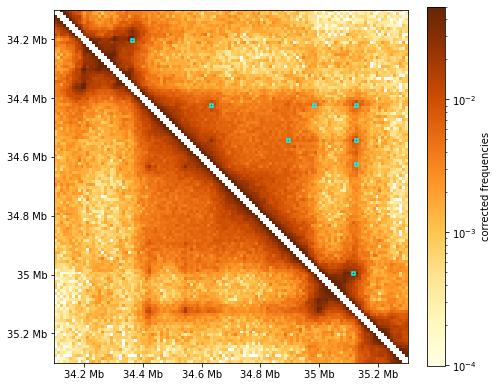

In [10]:
# define a region to look into as an example
start = 34_100_000
end = start + 1_200_000
region = ('chr17', start, end)

# heatmap kwargs
matshow_kwargs = dict(
    cmap='YlOrBr',
    norm=LogNorm(vmax=0.05),
    extent=(start, end, end, start)
)

# colorbar kwargs
colorbar_kwargs = dict(fraction=0.046, label='corrected frequencies')

# compute heatmap for the region
region_matrix = clr.matrix(balance=True).fetch(region)
for diag in [-1,0,1]:
    region_matrix = fill_diag(region_matrix, np.nan, i=diag)

# see viz.ipynb for details of heatmap visualization
f, ax = plt.subplots(figsize=(7,7))
im = ax.matshow( region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(dots_df, region, lw=1.5):
    ax.add_patch(box)


### Skipping clustering and strict enrichment filtering
Dot-calling returns pixels that are enriched relative to some local background. Such pixels often come in groups ("clusters"). By default `dots()` picks a single representative for each cluster (i.e. centroid). However, cooltools users can easily turn clustering off for debugging or alternative clustering approaches:

In [11]:
dots_df_all = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    max_loci_separation=10_000_000,
    clustering_radius=None,  # None - implies no clustering
    cluster_filtering=False,  # ignored when clustering is off
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root: matrix 9314X9314 to be split into 361 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 900 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 144 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 186 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 186 tiles
INFO:root:Done building histograms in 13.776 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 186 tiles to extract enriched pixels
INFO:root:creating a Pool of 4 workers to tackle 186 tile

The visualization below compares clustered dots (cyan) with all enriched pixels before clustering (blue)

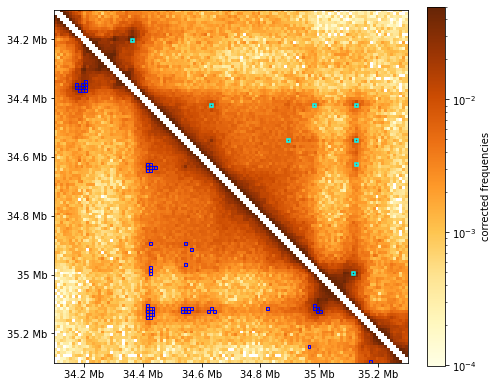

In [12]:
f, ax = plt.subplots(figsize=(7,7))
# draw heatmap
im = ax.matshow(region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in chain(
        rectangles_around_dots(dots_df, region, lw=1.5),  # clustered & filtered
        rectangles_around_dots(dots_df_all, region, loc="lower", ec="blue"),  # unclustered
    ):
    ax.add_patch(rect)

### local backgrounds for calculating enrichment of a pixel

Local background used to calculate the enrichment of pixels was empirically defined in [Rao et al. 2014](https://doi.org/10.1016/j.cell.2014.11.021) as a "donut"-shaped surrounding of a given pixel between ~20 to ~50 kb away from that pixel.

Such a local surrounding is best thought of in the terms of convolutional kernels e.g. as in [image processing](https://en.wikipedia.org/wiki/Kernel_(image_processing)), i.e. to calculate a local background of each pixel, ones has to convolve Hi-C heatmap with the "donut"-shaped kernel. Then the "brightness" of each pixel is compared to its local background to decide if it is enriched ot not.

Additional kernels were proposed to rule out unwanted enrichment types, such as elongated clusters or "stripes", TAD corners that do not "look" like dots, etc:
 - "vertical" to prevent calling pixels that are part of vertical stripes as dots
 - "horizontal" to prevent calling pixels that are part of horizontal stripes as dots
 - "lowleft" to prevent calling pixels that TAD corners
 

The visualization below demonstrates these 4 kernels, where pixels that are included in the calculations are highlighted in yellow, pixel of interest is highlighted in red, and pixels that are not included in the local background are purple.
Checkerboard pattern overlayed on the figure to emphasize individual pixels.


In [13]:
# function to draw kernels:
def draw_kernel(kernel, axis=None, cmap='viridis'):
    if axis is None:
        f, axis = plt.subplots()
    # kernel:
    imk = axis.imshow(
                    kernel[::-1,::-1],  # flip it, as in convolution
                    alpha=0.85,
                    cmap=cmap,
                    interpolation='nearest')
    # draw a square around the target pixel:
    x0 = kernel.shape[0] // 2 - 0.5
    y0 = kernel.shape[1] // 2 - 0.5
    rect = patches.Rectangle((x0, y0), 1, 1, lw=1, ec='r', fc='r')
    axis.add_patch(rect)

    # clean axis:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels('',visible=False)
    axis.set_yticklabels('',visible=False)
    axis.set_title("{} kernel".format(ktype),fontsize=16)
    # add a checkerboard to highlight pixels:
    checkerboard = np.add.outer(range(kernel.shape[0]),
                                range(kernel.shape[1])) % 2
    # show it:
    axis.imshow(checkerboard,
            cmap='gray',
            interpolation='nearest',
            alpha=0.3)

    return imk

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000


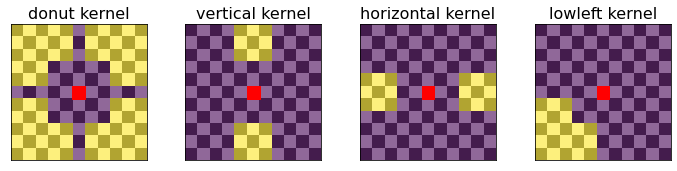

In [14]:
kernels = cooltools.api.dotfinder.recommend_kernels(binsize)

fig, axs = plt.subplots(ncols=4, figsize=(12,2.5))
for ax, (ktype, kernel) in zip(axs, kernels.items()):
    imk = draw_kernel(kernel, ax)

### Using same set of 4 kernels with more "rounded" donut

We can try to experiment with the kernels, e.g. by making them more round.
Again, kernels are defining the local area around a given pixel, that is used to test if a given pixel is enriched relative to it or not.

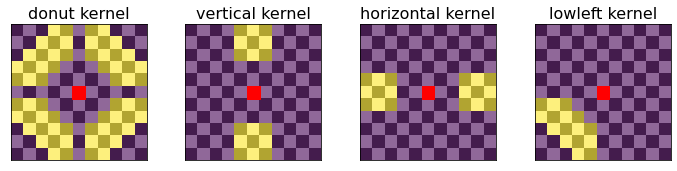

In [15]:
# create a grid of coordinates from -5 to 5, to define round kernels
# see https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html for details
half = 5  # half width of the kernel
x, y = np.meshgrid(
    np.linspace(-half, half, 2*half + 1),
    np.linspace(-half, half, 2*half + 1),
)
# now define a donut-like mask as pixels between 2 radii: sqrt(7) and sqrt(30):
mask = (x**2+y**2 > 7) & (x**2+y**2 <= 30)
mask[:,half] = 0
mask[half,:] = 0

# lowleft mask - zero out neccessary parts
mask_ll = mask.copy()
mask_ll[:,:half] = 0
mask_ll[half:,:] = 0

# new kernels with more round donut and lowleft masks:
kernels_round = {'donut': mask,
 'vertical': kernels["vertical"].copy(),
 'horizontal': kernels["horizontal"].copy(),
 'lowleft': mask_ll}

# plot rounded kernels
fig, axs = plt.subplots(ncols=4, figsize=(12,2.5))
for ax, (ktype, kernel) in zip(axs, kernels_round.items()):
    imk = draw_kernel(kernel, ax)

#### call dots using redefined kernels (without clustering) ...

In [16]:
dots_round_df_all = cooltools.dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    kernels=kernels_round, # provide custom kernels
    max_loci_separation=10_000_000,
    clustering_radius=20_000,
    nproc=4,
)

/home/sergpolly/miniconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:1565: UserWarning: Compatibility checks for 'kernels' are not fully implemented yet, use at your own risk
  warnings.warn(
INFO:root: matrix 9314X9314 to be split into 361 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 900 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 144 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 186 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 186 tiles
INFO:root:Done building histograms in 13.360 sec ...
INFO:root:Determined thresholds for

In [17]:
region

('chr17', 34100000, 35300000)

In [18]:
dots_round_df_all

,chrom1,start1,end1,chrom2,start2,end2,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,...,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval,region,cstart1,cstart2,c_label,c_size,region1,region2
0,chr17,2820000,2830000,chr17,3640000,3650000,154,30.311625,32.995433,35.446198,...,7.235828e-40,6.643442e-40,2.917881e-51,chr17_p,2.824286e+06,3.642857e+06,1,7,chr17_p,chr17_p
1,chr17,4420000,4430000,chr17,4620000,4630000,148,27.771489,29.361062,27.471726,...,2.313203e-47,2.329139e-47,1.786683e-36,chr17_p,4.425000e+06,4.618333e+06,2,4,chr17_p,chr17_p
2,chr17,3910000,3920000,chr17,4410000,4420000,84,21.874146,22.052639,21.375101,...,1.506559e-17,1.299432e-17,1.336361e-17,chr17_p,3.913333e+06,4.406667e+06,3,3,chr17_p,chr17_p
3,chr17,4560000,4570000,chr17,4880000,4890000,222,47.861576,52.086791,50.996481,...,2.347949e-51,2.514098e-51,2.087051e-67,chr17_p,4.562857e+06,4.884286e+06,4,5,chr17_p,chr17_p
4,chr17,3860000,3870000,chr17,4000000,4010000,193,77.836823,105.110365,82.348635,...,3.507645e-07,6.445267e-15,8.740008e-25,chr17_p,3.850000e+06,4.000000e+06,5,3,chr17_p,chr17_p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3238,chr2,102240000,102250000,chr2,102350000,102360000,403,137.612999,159.101814,107.087491,...,2.203770e-56,4.268458e-82,1.592018e-34,chr2_q,1.022500e+08,1.023475e+08,2393,4,chr2_q,chr2_q
3239,chr2,105120000,105130000,chr2,105290000,105300000,144,67.562852,61.902030,87.306831,...,2.686639e-16,3.005592e-04,3.354752e-16,chr2_q,1.051200e+08,1.052900e+08,2394,2,chr2_q,chr2_q
3240,chr2,105110000,105120000,chr2,105540000,105550000,68,20.817200,26.851522,21.254448,...,1.415321e-06,3.499122e-10,2.403043e-14,chr2_q,1.051100e+08,1.055400e+08,2395,2,chr2_q,chr2_q
3241,chr2,103160000,103170000,chr2,104840000,104850000,92,12.761487,12.397901,17.438864,...,1.345599e-42,3.199740e-28,3.327261e-43,chr2_q,1.031600e+08,1.048533e+08,2396,3,chr2_q,chr2_q


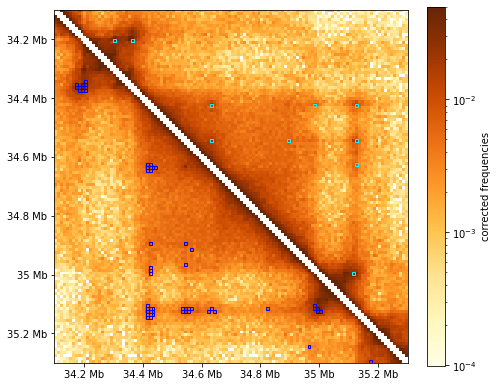

In [19]:
f, ax = plt.subplots(figsize=(7,7))
# draw heatmap
im = ax.matshow(region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in chain(
        rectangles_around_dots(dots_round_df_all, region),
        rectangles_around_dots(dots_df_all, region, loc="lower", ec="blue"),
    ):
    ax.add_patch(rect)

In [20]:
# create a functions that would return a series of rectangles around called dots
# in a specific region, and exposing importnat plotting parameters
def rectangles_around_dots(dots_df, region, loc="upper", lw=0, ec="darkgreen", fc="none"):
    """
    yield a series of rectangles around called dots in a given region
    """
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=ec, alpha=0.4)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        _size = kernels_round["donut"].shape[0]//2
        width1 = e1 - s1
        width2 = e2 - s2
        # rectangle_kwargs = dict(lw=1, ec="blue", fc="none")
        # yield patches.Rectangle((s2, s1), width2, width1, **rectangle_kwargs)
        rectangle_kwargs = dict(lw=lw, ec=ec, fc=ec, alpha=0.4)
        for i,row in enumerate(kernels_round["donut"]):
            for j,elem in enumerate(row):
                # print(i-5,j-5,elem)
                if elem:
                    yield patches.Rectangle(
                        (s2+(i-5)*width1, s1+(j-5)*width2),
                        width2,
                        width1,
                        **rectangle_kwargs
                    )

def get_snippets_around_dots(dots_df, region, extension=2):
    """
    yield a series of rectangles around called dots in a given region
    """
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        _size = kernels_round["donut"].shape[0]//2 + extension
        width1 = e1 - s1
        width2 = e2 - s2
        yield (
            (region[0], s1-_size*width1, s1+(_size+1)*width1),
            (region[0], s2-_size*width2, s2+(_size+1)*width2),
              )

# function to draw kernels:
def draw_kernel_II(kernel, axis=None, cmap='viridis'):
    if axis is None:
        f, axis = plt.subplots()
    # kernel:
    imk = axis.imshow(
                    kernel[::-1,::-1],  # flip it, as in convolution
                    alpha=0.4,
                    cmap=cmap,
                    interpolation='none')
    # # draw a square around the target pixel:
    # x0 = kernel.shape[0] // 2 - 0.5
    # y0 = kernel.shape[1] // 2 - 0.5

    # # add a checkerboard to highlight pixels:
    # checkerboard = np.add.outer(range(kernel.shape[0]),
    #                            range(kernel.shape[1])) % 2
    #     # show it:
    #     axis.imshow(checkerboard,
    #             cmap='gray',
    #             interpolation='nearest',
    #             alpha=0.3)

    return imk

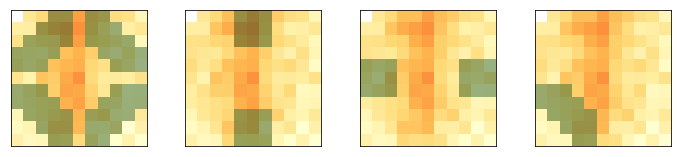

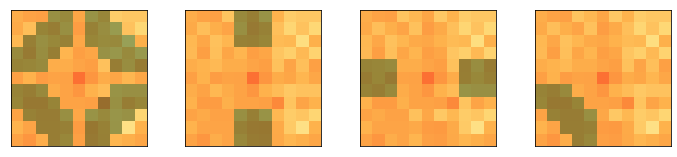

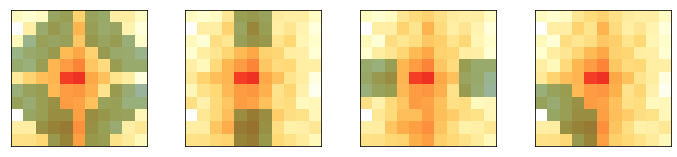

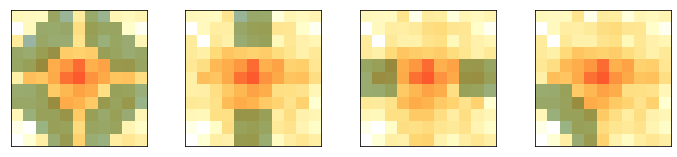

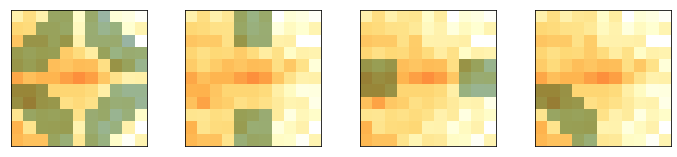

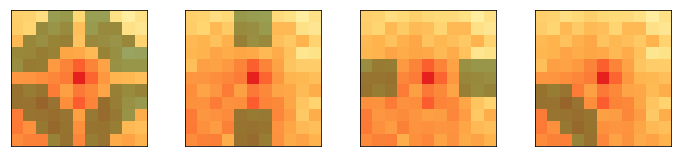

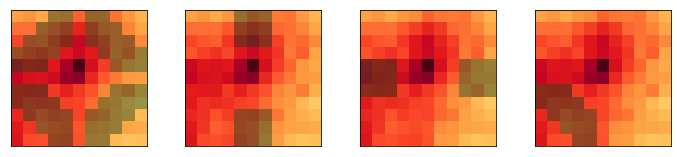

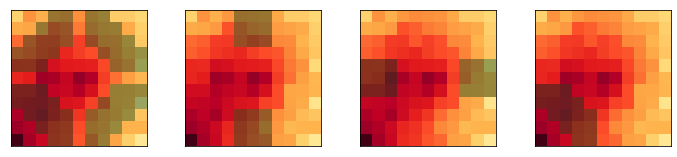

In [21]:
# heatmap kwargs
snippet_kwargs = dict(
    cmap='fall',
    norm=LogNorm(vmax=0.1),
#     extent=(start, end, end, start)
)


for iii,(r1, r2) in enumerate(get_snippets_around_dots(dots_df, region, 0)):
    # compute heatmap for the region
    _matrix = clr.matrix(balance=True).fetch(r1,r2)
    # see viz.ipynb for details of heatmap visualization
    fig, axs = plt.subplots(ncols=4, figsize=(12,2.5))
    for ax, (ktype, kernel) in zip(axs, kernels_round.items()):
        if ktype in ["vertical","horizontal"]:
            xxx = kernel.copy().astype(float)
            xxx[kernel==0] = np.nan
        else:
            xxx = kernel.copy().astype(float)
            xxx[~kernel] = np.nan

        # snippet_kwargs["extent"] = (r1[0], r1[1], r2[1], r2[0])
        im = ax.matshow( _matrix, **snippet_kwargs)
        imk = draw_kernel_II(xxx, ax, cmap="Greens_r")
        
        #
        # clean axis:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels('',visible=False)
        ax.set_yticklabels('',visible=False)

    plt.show()


In [25]:
from matplotlib.cm import register_cmap
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

PALETTES = {
    "fall": np.array(
        (
            (255, 255, 255),
            (255, 255, 204),
            (255, 237, 160),
            (254, 217, 118),
            (254, 178, 76),
            (253, 141, 60),
            (252, 78, 42),
            (227, 26, 28),
            (189, 0, 38),
            (128, 0, 38),
            (0, 0, 0),
        )
    )
    / 255,
}


def list_to_colormap(color_list, name=None):
    color_list = np.array(color_list)
    if color_list.min() < 0:
        raise ValueError("Colors should be 0 to 1, or 0 to 255")
    if color_list.max() > 1.0:
        if color_list.max() > 255:
            raise ValueError("Colors should be 0 to 1 or 0 to 255")
        else:
            color_list = color_list / 255.0
    return mpl.colors.LinearSegmentedColormap.from_list(name, color_list, 256)


def get_cmap(name):
    is_reversed = name.endswith("_r")
    try:
        if is_reversed:
            pal = PALETTES[name[:-2]][::-1]
        else:
            pal = PALETTES[name]
    except KeyError:
        raise ValueError('Palette not found "{}"'.format(name))
    return list_to_colormap(pal, name)

# def _register_cmaps():
#     for name, pal in PALETTES.items():
#         register_cmap(name, list_to_colormap(pal))
#         register_cmap(name + "_r", list_to_colormap(pal[::-1]))

# _register_cmaps()
fall_hm = get_cmap("fall")

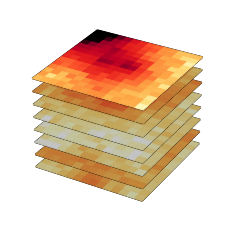

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

_norm_hm_colors = LogNorm(vmax=0.1)

dimens = kernels_round["donut"].shape[0]//2 + 2
dimens = 2*dimens + 1

# create a 21 x 21 vertex mesh
xx, yy = np.meshgrid(np.linspace(0,1,dimens), np.linspace(0,1,dimens))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  np.zeros_like(X)

# create the figure
fig = plt.figure()

# show the 3D rotated projection
ax2 = fig.add_subplot(111, projection='3d')

num_to_show = 7

for ii,(r1, r2) in enumerate(get_snippets_around_dots(dots_df, region)):
    if ii > num_to_show:
        break
    # top_element = ii!=0
    top_element = ii!=num_to_show
    # compute heatmap for the region
    _matrix = clr.matrix(balance=True).fetch(r1,r2)
    ax2.plot_wireframe(X, Y, Z+ii/num_to_show, rstride=1, cstride=1,color="black")
    ax2.plot_surface(
        X,
        Y,
        Z+ii/num_to_show,
        rstride=1,
        cstride=1,
        facecolors=fall_hm(_norm_hm_colors(_matrix)),
        shade=top_element,
#         alpha=0.9 if top_element else 0.99,
#         edgecolor="black",
#         linewidth=0.3
    )
ax2.set_axis_off()
plt.savefig("xxx.pdf")

In [27]:
# #### f, ax = plt.subplots(figsize=(7,7))
# # draw heatmap
# matshow_kwargs["cmap"]="fall"
# matshow_kwargs["norm"]=LogNorm(vmax=0.1)
# im = ax.matshow(region_matrix, **matshow_kwargs)
# format_ticks(ax, rotate=False)
# plt.colorbar(im, ax=ax, **colorbar_kwargs)

# # draw rectangular "boxes" around pixels called as dots in the "region":
# for rect in chain(
#         rectangles_around_dots(dots_round_df_all, region),
#     ):
#     ax.add_patch(rect)

The visualization below compares dots called using "rounded" kernels (cyan) with the dots called using recommended kernels (blue). As one can tell the results are similar, yet the "rounded" kernels allow for calling dots closer to the diagonal because of the shape of the kernel.

In [28]:
def plain_rectangles_around_dots(dots_df, region, window_size=10**5, lw=2, ec="darkgreen", fc="none", alpha=0.4):
    """
    yield a series of rectangles around called dots in a given region
    """
    
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc, alpha=alpha)
    
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        mid1 = (s1+e1)/2
        mid2 = (s2+e2)/2
        
        yield patches.Rectangle(
                        (mid2-window_size//2, mid1-window_size//2),
                        window_size,
                        window_size,
                        **rectangle_kwargs
                    )

In [29]:
matshow_kwargs["cmap"] = "fall"

In [30]:
from matplotlib.ticker import FuncFormatter

In [31]:
def millions(x, pos):
    return f"{float(x)/1e6:.1f}"

formatter = FuncFormatter(millions)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 31 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'M', 'b', 'c', 'comma', 'd', 'e', 'eight', 'f', 'five', 'four', 'h', 'i', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 48, 69, 70, 71, 72, 73, 75, 76, 81, 82, 84, 85, 86, 87, 88, 3228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 34 glyphs after
INFO:fontTools.subset:Glyph names: 

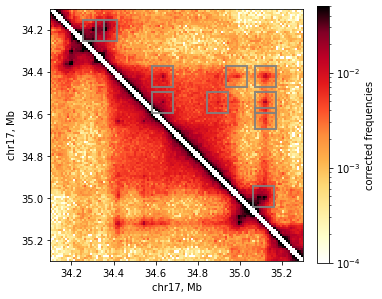

In [32]:
f, ax = plt.subplots(figsize=(5,5))
# draw heatmap
im = ax.matshow(region_matrix, aspect='equal', **matshow_kwargs)
format_ticks(ax, rotate=False, formatter=formatter)
ax.set_ylabel(f"{region[0]}, Mb")
ax.set_xlabel(f"{region[0]}, Mb")
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in plain_rectangles_around_dots(dots_round_df_all, region, ec="0.5", alpha=0.9):
    ax.add_patch(rect)
    
plt.savefig("heatmap.pdf", bbox_inches="tight")